# German Traffic Sign Classifier using a LeNet based Convolutional Network

## Pipeline Approach

In this project, I'm building pipelines to classify the traffic signs from the [German Traffic Sign](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset) Benchmarks.

The starting model is a convolutional network based on the [LeNet](http://yann.lecun.com/exdb/lenet/) architecture by Yann LeCun.  LeNet was originally designed for handwritten and machine-printed character recognition. 

The project is explained in the following sections.

* Data Exploratory Analysis
* Model Implementation
* Preprocessing
* Model Evaluation
* Testing and Results


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Import Libraries

In [2]:
import glob
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import random
import matplotlib.image as mpimg
import cv2
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.contrib.layers import flatten
from sklearn.utils import shuffle
import warnings
from skimage import exposure
# Load pickled data
import pickle

matplotlib.style.use('ggplot')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

---

## Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

In [2]:
## Load the data

training_file = "./traffic-signs-data/train.p"
testing_file = "./traffic-signs-data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X, y = train['features'], train['labels']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, stratify=y, test_size=4000, random_state=0)

X_test, y_test = test['features'], test['labels']

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_valid shape:", X_valid.shape)
print("y_valid shape:", y_valid.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
N_CLASSES = np.unique(y_train).size  # keep this for later

X_train shape: (35209, 32, 32, 3)
y_train shape: (35209,)
X_valid shape: (4000, 32, 32, 3)
y_valid shape: (4000,)
X_test shape: (12630, 32, 32, 3)
y_test shape: (12630,)


---
## Data Analysis

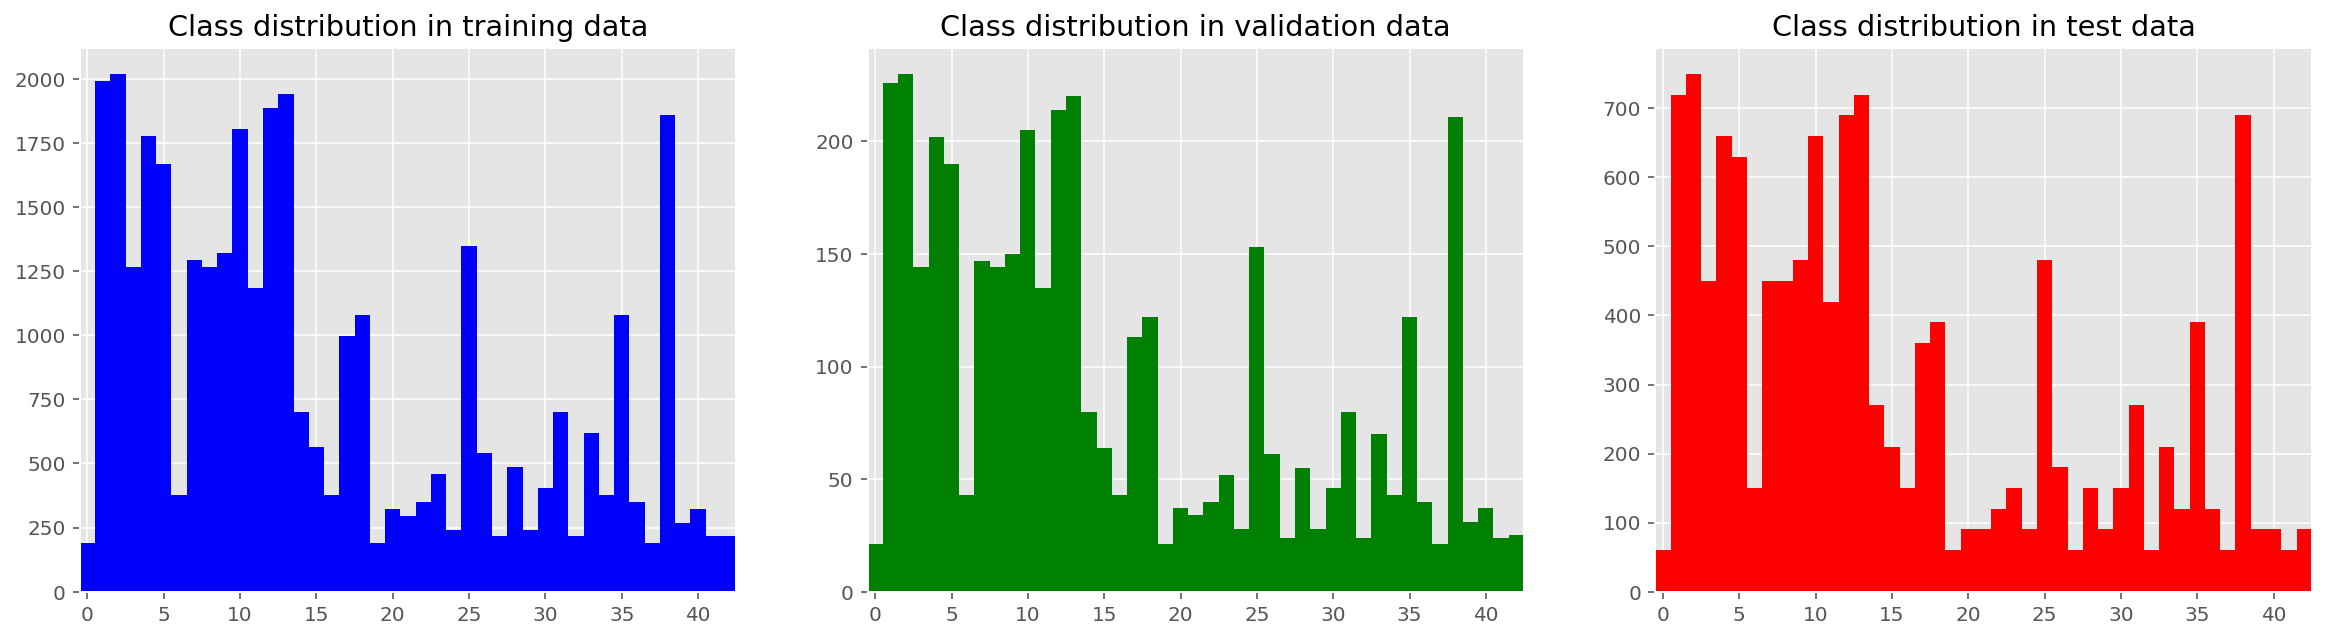

In [3]:
def plot_dist(y_data, title=None, ax=None, **kwargs):
    '''
    Plot the traffic sign class distribution
    '''
    if not ax :
        fig = plt.figure()
        ax = fig.add_subplot(111)
    ax.hist(y_data, np.arange(-0.5, N_CLASSES+1.5), stacked=True, **kwargs)
    ax.set_xlim(-0.5,N_CLASSES-0.5)
    if 'label' in kwargs : ax.legend()
    if title : ax.set_title(title)
        
fig,ax = plt.subplots(1,3, figsize=(20,5))
plot_dist(y_train, title='Class distribution in training data', ax=ax[0], color='blue')
plot_dist(y_valid, title='Class distribution in validation data', ax=ax[1], color='green')
plot_dist(y_test, title='Class distribution in test data', ax=ax[2], color='red')

The class ditribution in train and test sets look very similar. Even if we did not balance dataset, it is possible to obtain a reasonable accuracy for this particular testset. However, for new test sets with different class distributions, accuracy will go down. Therefore, we need to balance our training set later by data augmentation.

### Sign and class labels mappings

In [4]:
## let's create a pandas dataframe to load csv

sign_name_df = pd.read_csv('signnames.csv')
SIGN_NAMES = sign_name_df.SignName.values
sign_name_df.set_index('ClassId',inplace=True)
sign_name_df.head()

,SignName
ClassId,
0,Speed limit (20km/h)
1,Speed limit (30km/h)
2,Speed limit (50km/h)
3,Speed limit (60km/h)
4,Speed limit (70km/h)


In [5]:
## Helper function for finding lables for class-id (later used)
def get_name_from_label(label):
    # Helper, transofrm a numeric label into the corresponding strring
    return sign_name_df.loc[label].SignName

### Helper function for plotting accuracy graphs and confusion matrix

In [6]:
def show_learning_curve(train, valid, epochs=range(1, 21, 1)):
    plt.figure(figsize=(10, 10))
    plt.plot(epochs, train, label='train')
    plt.plot(epochs, valid, label='validation')
    plt.title('Training and Validation Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epochs')
    plt.xticks(epochs)
    plt.legend(loc='center right')

def plot_confusion_matrix(cm):
    cm = [row/sum(row)   for row in cm]
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm, cmap=plt.cm.Oranges)
    fig.colorbar(cax)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Class IDs')
    plt.ylabel('True Class IDs')
    plt.show()

def print_confusion_matrix(cm, sign_names=SIGN_NAMES):
    results = [(i, SIGN_NAMES[i], row[i]/sum(row)*100) for i, row in enumerate(cm)]
    accuracies = []
    for result in sorted(results, key=lambda x: -x[2]):
        print('{:>2} {:<50} {:6.2f}% {:>4}'.format(*result, sum(y_train==result[0])))
        accuracies.append(result[2])
    print('-'*50)
    print('Accuracy: Mean: {:.3f} Std: {:.3f}'.format(np.mean(accuracies), np.std(accuracies)))

### Let's check occuranes of different signs

In [7]:
sign_name_df['Occurence'] = [sum(y_train == c) for c in range(N_CLASSES)]
sign_name_df.sort_values('Occurence', ascending=False)

,SignName,Occurence
ClassId,,
2,Speed limit (50km/h),2020
1,Speed limit (30km/h),1994
13,Yield,1940
12,Priority road,1886
38,Keep right,1859
10,No passing for vehicles over 3.5 metric tons,1805
4,Speed limit (70km/h),1778
5,Speed limit (80km/h),1670
25,Road work,1347


In [8]:
def get_samples(num_samples, class_id=None):
    """
    Randomly select image filenames and their class IDs
    """
    if class_id is not None:
        if len(list(np.where(y_train==class_id))[0].tolist()) < num_samples:
            num_samples = len(list(np.where(y_train==class_id))[0].tolist())
        indices = random.sample(list(np.where(y_train==class_id))[0].tolist(), num_samples)
        return X_train[indices], y_train[indices]
    else:
        indices = np.random.choice(X_train.shape[0], size=num_samples, replace=False)
        return X_train[indices], y_train[indices]

In [9]:
def show_images(sample_x, sample_y, cols=5, sign_names=None, show_shape=False):
    """
    Given a list of images, load and show them.
    """
    
    num_images = len(sample_x)
    rows = num_images//cols
    fig, axes = plt.subplots(rows, cols, figsize=(cols*4,rows*2.5))
    indexes = range(cols * rows)
    i = 1 
    for ax, index in zip(axes.flat, indexes):    
        image = sample_x[index]
        label = sample_y[index]
        if image.shape[2] == 1:
            ax.imshow(image.reshape(32,32), cmap='gray')
        else:
            ax.imshow(image)
                      
        if sign_names is not None:
            ax.text(0, 0, '{}: {}'.format(label, sign_names[label]), color='k',backgroundcolor='c', fontsize=8)        
        if show_shape:
            ax.text(0, image.shape[0], '{}'.format(image.shape), color='k',backgroundcolor='y', fontsize=8)        

        ax.set_xticks([], minor=False)
        ax.set_yticks([], minor=False)
        i += 1
    

## Random sample images from our dataset

Generating Random samples..


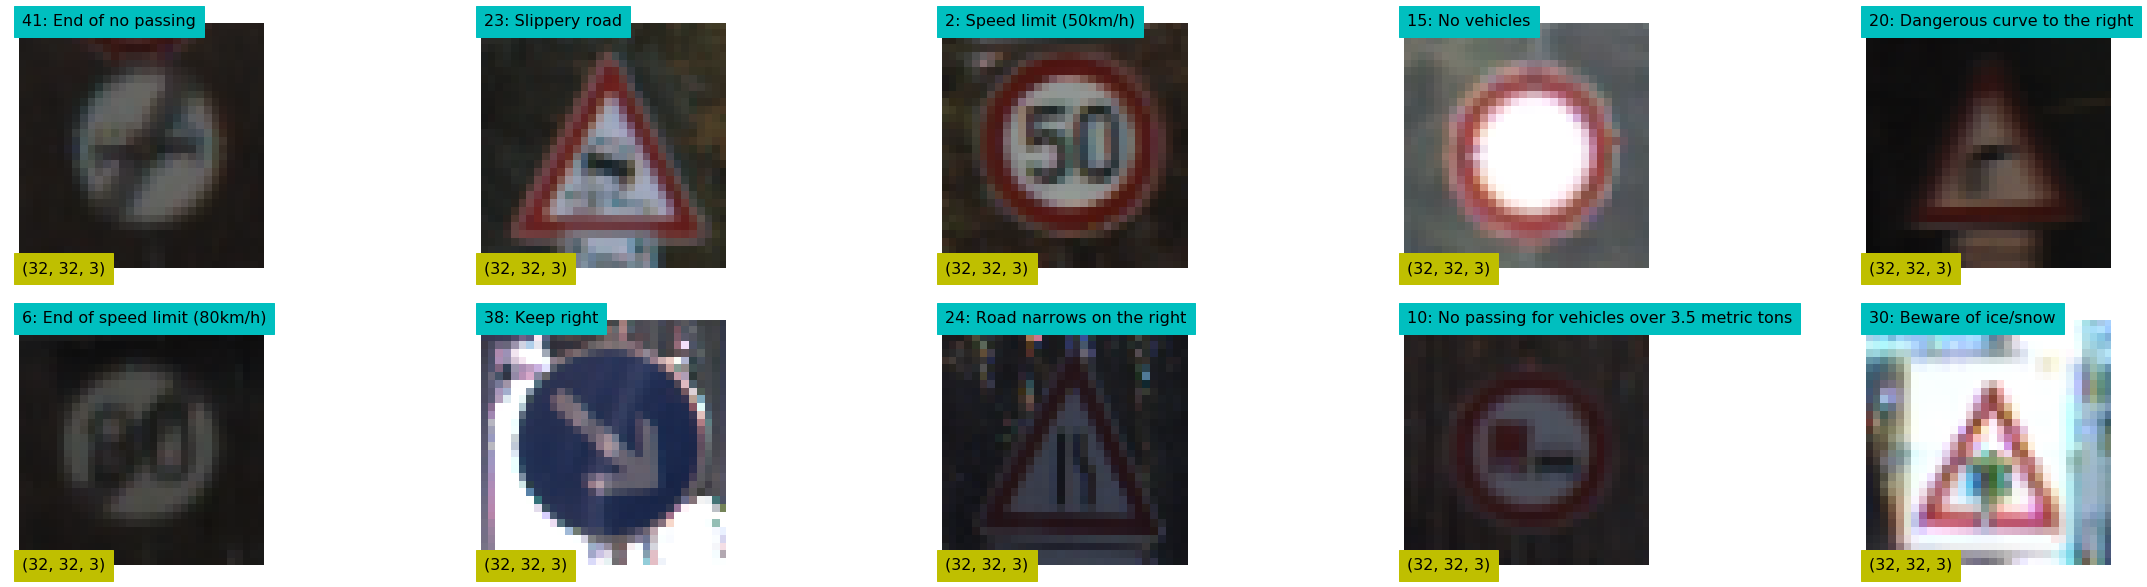

In [10]:
sample_x, sample_y = get_samples(10)
print("Generating Random samples..")
show_images(sample_x, sample_y, sign_names=SIGN_NAMES, show_shape=True)

## Images of a single sign

Speed limit (50km/h)


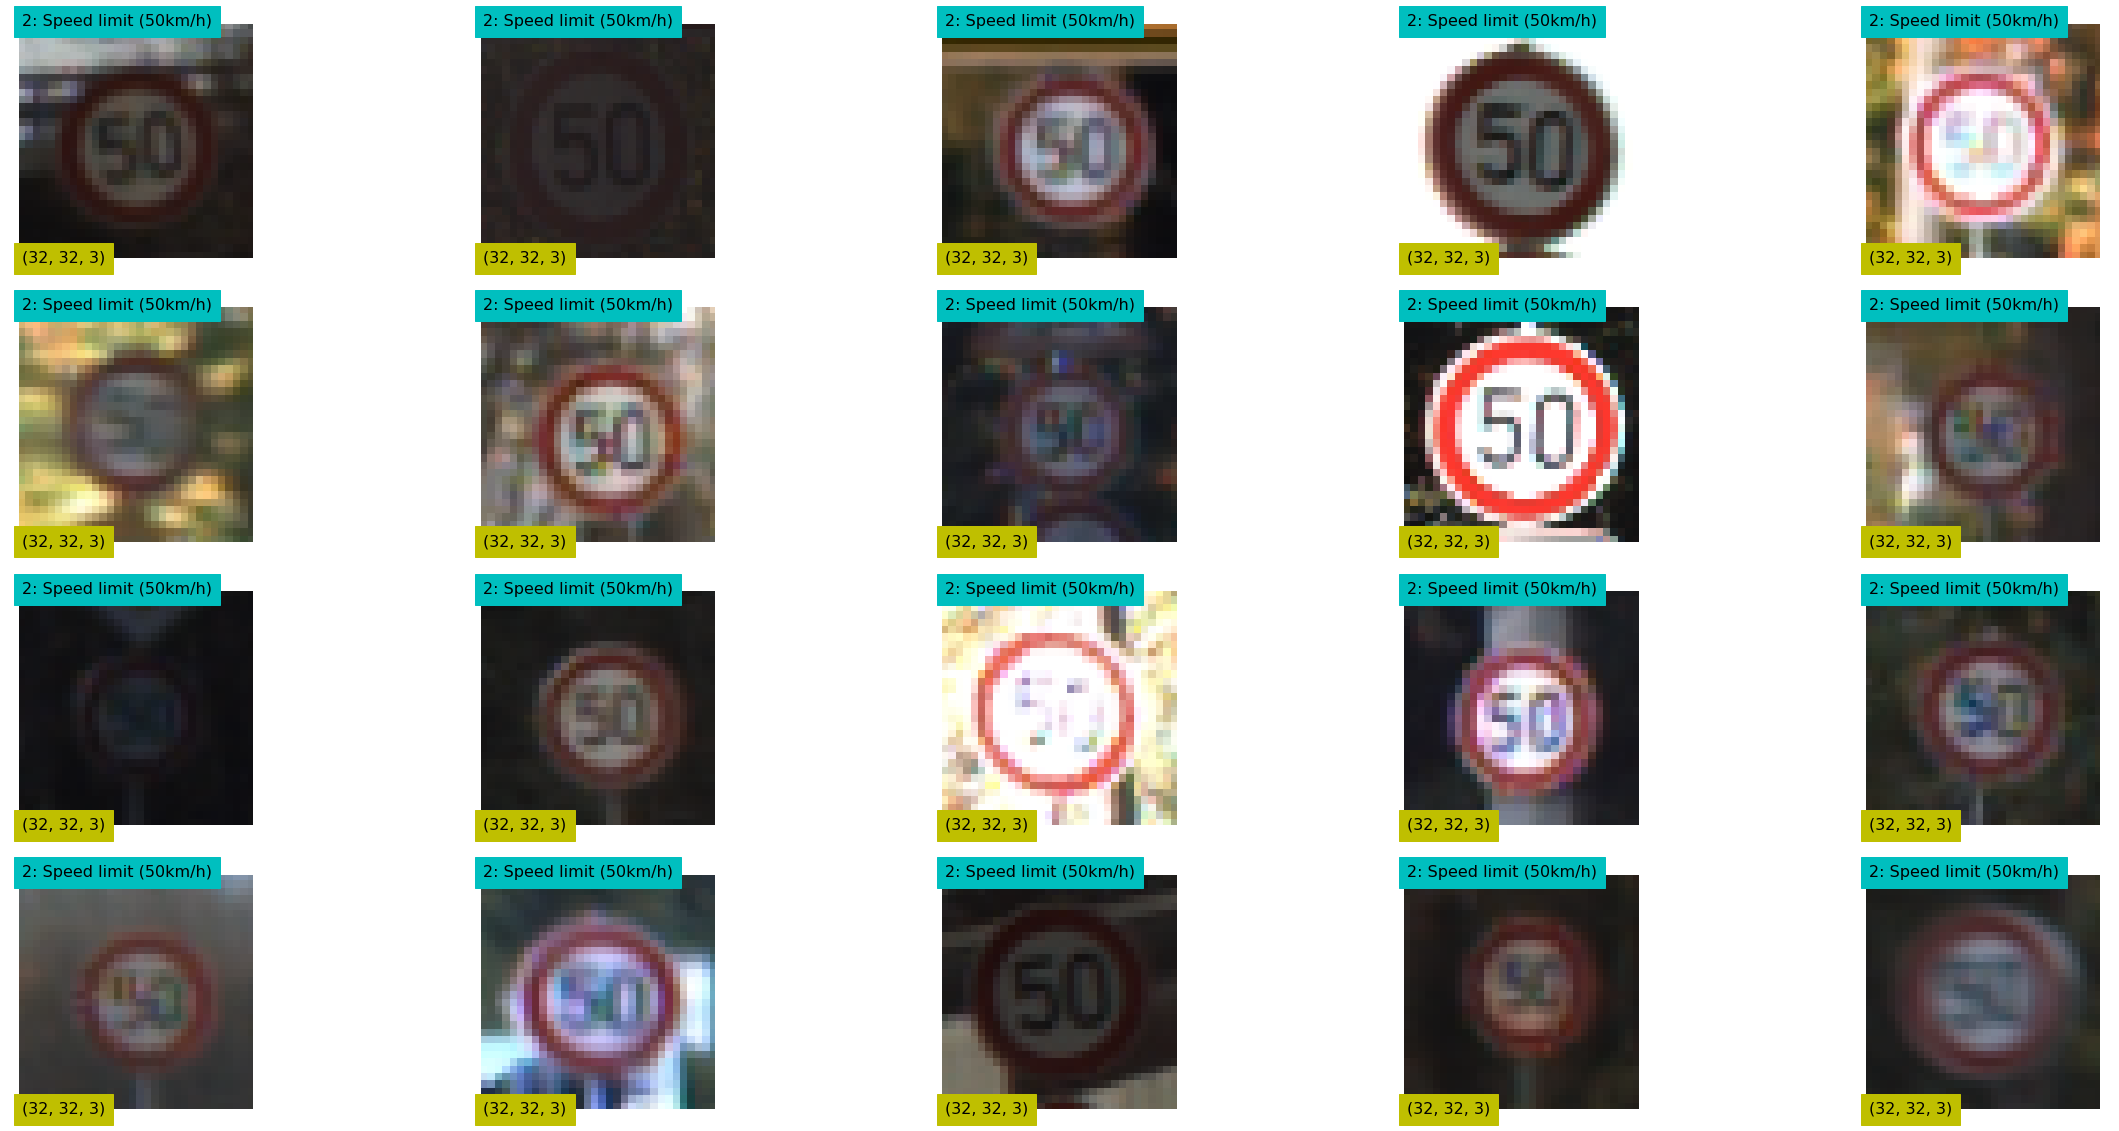

In [11]:
sample_x_2, sample_y_2 = get_samples(num_samples=20, class_id=2)
print(SIGN_NAMES[2])
show_images(sample_x_2, sample_y_2, sign_names=SIGN_NAMES, show_shape=True)

---
# Model Implementation

## Model Architecture

The model is based on [LeNet](http://yann.lecun.com/exdb/lenet/) by Yann LeCun.  It is a convolutional neural network designed to recognize visual patterns directly from pixel images with minimal preprocessing.  It can handle hand-written characters very well. 

![LeNet](images/lenet.png)

Source: http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf

- The inputs are 32x32 (Black-White 1 channel) images
- LeNet uses 2x2 sub-sampling (valid padding, max pooling) in convolutional layers (no dropout)
- LeNet uses a sigmoid squashing function - a scaled hyperbolic tangent: $Atanh(Sa)$ where A=1.7159 and S=2/3
- LeNet has one 7x12 bitmap for each class, which is a label.  There are 10 classes (the digits '0' - '9')
- 7x12 = 84 which is why the output is 84
- The output is compared with all the labels (bitmaps) to calculate the error
- The class with the smallest error is an estimated digit value

Our model is adapted from the LeNet as follows.  

- The inputs are 32x32 (RGB - 3 channels) images
- The activation function is ReLU except for the output layer which uses Softmax
- The output has 43 classes

|Layer                       | Shape    |
|----------------------------|:--------:|
|Input                       | 32x32x3  |
|Convolution (valid, 5x5x6)  | 28x28x6  |
|Max Pooling (valid, 2x2)    | 14x14x6  |
|Activation  (ReLU)          | 14x14x6  |
|Convolution (valid, 5x5x16) | 10x10x16 |
|Max Pooling (valid, 2x2)    | 5x5x16   |
|Activation  (ReLU)          | 5x5x16   |
|Flatten                     | 400      |
|Dense                       | 120      |
|Activation  (ReLU)          | 120      |
|Dense                       | 43       |
|Activation  (Softmax)       | 43       |

In [12]:
class LaNet:  

    def __init__(self, n_out=43, mu=0, sigma=0.1, learning_rate=0.001, input_channels = 3):
        # Hyperparameters
        self.mu = mu
        self.sigma = sigma

        # Layer 1 (Convolutional): Input = 32x32x3. Output = 28x28x6.
        self.filter1_width = 5
        self.filter1_height = 5
        self.input1_channels = input_channels
        self.conv1_output = 6
        # Weight and bias
        self.conv1_weight = tf.Variable(tf.truncated_normal(
            shape=(self.filter1_width, self.filter1_height, self.input1_channels, self.conv1_output),
            mean = self.mu, stddev = self.sigma))
        self.conv1_bias = tf.Variable(tf.zeros(self.conv1_output))
        # Apply Convolution
        self.conv1 = tf.nn.conv2d(x, self.conv1_weight, strides=[1, 1, 1, 1], padding='VALID') + self.conv1_bias
        
        # Activation:
        self.conv1 = tf.nn.relu(self.conv1)
        
        # Pooling: Input = 28x28x6. Output = 14x14x6.
        self.conv1 = tf.nn.max_pool(self.conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
        
        # Layer 2 (Convolutional): Output = 10x10x16.
        self.filter2_width = 5
        self.filter2_height = 5
        self.input2_channels = 6
        self.conv2_output = 16
        # Weight and bias
        self.conv2_weight = tf.Variable(tf.truncated_normal(
            shape=(self.filter2_width, self.filter2_height, self.input2_channels, self.conv2_output),
            mean = self.mu, stddev = self.sigma))
        self.conv2_bias = tf.Variable(tf.zeros(self.conv2_output))
        # Apply Convolution
        self.conv2 = tf.nn.conv2d(self.conv1, self.conv2_weight, strides=[1, 1, 1, 1], padding='VALID') + self.conv2_bias
        
        # Activation:
        self.conv2 = tf.nn.relu(self.conv2)
        
        # Pooling: Input = 10x10x16. Output = 5x5x16.
        self.conv2 = tf.nn.max_pool(self.conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
        
        # Flattening: Input = 5x5x16. Output = 400.
        self.fully_connected0 = flatten(self.conv2)
        
        # Layer 3 (Fully Connected): Input = 400. Output = 120.
        self.connected1_weights = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = self.mu, stddev = self.sigma))
        self.connected1_bias = tf.Variable(tf.zeros(120))
        self.fully_connected1 = tf.add((tf.matmul(self.fully_connected0, self.connected1_weights)), self.connected1_bias)
        
        # Activation:
        self.fully_connected1 = tf.nn.relu(self.fully_connected1)
    
        # Layer 4 (Fully Connected): Input = 120. Output = 84.
        self.connected2_weights = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = self.mu, stddev = self.sigma))
        self.connected2_bias = tf.Variable(tf.zeros(84))
        self.fully_connected2 = tf.add((tf.matmul(self.fully_connected1, self.connected2_weights)), self.connected2_bias)
        
        # Activation.
        self.fully_connected2 = tf.nn.relu(self.fully_connected2)
    
        # Layer 5 (Fully Connected): Input = 84. Output = 43.
        self.output_weights = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = self.mu, stddev = self.sigma))
        self.output_bias = tf.Variable(tf.zeros(43))
        self.logits = tf.add((tf.matmul(self.fully_connected2, self.output_weights)), self.output_bias)

        # Training operation
        self.one_hot_y = tf.one_hot(y, n_out)
        self.cross_entropy = tf.nn.softmax_cross_entropy_with_logits(self.logits, self.one_hot_y)
        self.loss_operation = tf.reduce_mean(self.cross_entropy)
        self.optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
        self.training_operation = self.optimizer.minimize(self.loss_operation)
        self.predict_operation = tf.argmax(self.logits, 1)
        self.predict_proba_operation = tf.nn.softmax(logits=self.logits)

        # Accuracy operation
        self.correct_prediction = tf.equal(tf.argmax(self.logits, 1), tf.argmax(self.one_hot_y, 1))
        self.accuracy_operation = tf.reduce_mean(tf.cast(self.correct_prediction, tf.float32))

        # Saving all variables
        self.saver = tf.train.Saver()
    
    def get_batch(self, X_data, y_data, start, BATCH_SIZE=128):
        end = start + BATCH_SIZE
        return X_data[start:end], y_data[start:end]
    
    def y_predict(self, X_data, BATCH_SIZE=64):
        num_examples = len(X_data)
        y_pred = np.zeros(num_examples, dtype=np.int32)
        sess = tf.get_default_session()
        for offset in range(0, num_examples, BATCH_SIZE):
            batch_x = X_data[offset:offset+BATCH_SIZE]
            y_pred[offset:offset+BATCH_SIZE] = sess.run(self.predict_operation, 
                               feed_dict={x:batch_x, keep_prob:1})
        return y_pred
    
    def evaluate(self, X_data, y_data, BATCH_SIZE=64):
        num_examples = len(X_data)
        total_accuracy = 0
        sess = tf.get_default_session()
        for offset in range(0, num_examples, BATCH_SIZE):
            batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
            accuracy = sess.run(self.accuracy_operation, 
                                feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
            total_accuracy += (accuracy * len(batch_x))
        return total_accuracy / num_examples
    
    def predict(self, X_data, BATCH_SIZE=64):
        num_examples = len(X_data)
        sess = tf.get_default_session()
        predicted_proba = list()
        for offset in range(0, num_examples, BATCH_SIZE):
            batch_x = X_data[offset:offset+BATCH_SIZE]
            predicted_proba.extend( sess.run(self.predict_proba_operation, feed_dict={x: batch_x, keep_prob: 1.0}))
        
        return predicted_proba

In [13]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)

In [14]:
def run_LeNet():

    BATCH_SIZE = 128
    NUMBER_OF_TRAINING_DATA = X_train.shape[0]
    EPOCHS = 20
    DIR = 'Saved_Models'

    LeNet_Model = LaNet(n_out = 43, input_channels = 3)
    model_name = "LeNet_rgb"
    validation_accuracy_figure = []
    train_accuracy_figure = []

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        num_examples = len(y_train)
        print("Training ...")
        print()
        for epoch in range(EPOCHS):
            X_data, y_data = shuffle(X_train, y_train)
            for offset in range(0, NUMBER_OF_TRAINING_DATA, BATCH_SIZE):
                batch_x, batch_y = LeNet_Model.get_batch(X_data, y_data, offset, BATCH_SIZE) 
                _, loss = sess.run([LeNet_Model.training_operation, LeNet_Model.loss_operation], feed_dict={x: batch_x, y: batch_y, keep_prob : 0.5})

            validation_accuracy = LeNet_Model.evaluate(X_valid, y_valid)
            validation_accuracy_figure.append(validation_accuracy)

            train_accuracy = LeNet_Model.evaluate(X_train, y_train)
            train_accuracy_figure.append(train_accuracy)

            print("Epoch: {:3d},".format(epoch), "Train Acc: {:.3f}, ".format(train_accuracy), 
                  "Validation Acc: {:.3f}, ".format(validation_accuracy), 
                  "loss: {:.3f}".format(loss))
        LeNet_Model.saver.save(sess, os.path.join(DIR, model_name))
        print("Model saved")

    return LeNet_Model, train_accuracy_figure, validation_accuracy_figure


In [15]:
LeNet_Model, train_accuracy_figure, validation_accuracy_figure = run_LeNet()

Training ...

Epoch:   0, Train Acc: 0.554,  Validation Acc: 0.554,  loss: 1.032
Epoch:   1, Train Acc: 0.776,  Validation Acc: 0.761,  loss: 0.959
Epoch:   2, Train Acc: 0.866,  Validation Acc: 0.854,  loss: 0.339
Epoch:   3, Train Acc: 0.887,  Validation Acc: 0.872,  loss: 0.054
Epoch:   4, Train Acc: 0.923,  Validation Acc: 0.900,  loss: 0.071
Epoch:   5, Train Acc: 0.945,  Validation Acc: 0.915,  loss: 0.127
Epoch:   6, Train Acc: 0.948,  Validation Acc: 0.916,  loss: 0.015
Epoch:   7, Train Acc: 0.946,  Validation Acc: 0.916,  loss: 0.088
Epoch:   8, Train Acc: 0.958,  Validation Acc: 0.921,  loss: 0.817
Epoch:   9, Train Acc: 0.964,  Validation Acc: 0.936,  loss: 0.183
Epoch:  10, Train Acc: 0.970,  Validation Acc: 0.938,  loss: 0.412
Epoch:  11, Train Acc: 0.965,  Validation Acc: 0.934,  loss: 0.339
Epoch:  12, Train Acc: 0.978,  Validation Acc: 0.949,  loss: 0.040
Epoch:  13, Train Acc: 0.972,  Validation Acc: 0.947,  loss: 0.019
Epoch:  14, Train Acc: 0.978,  Validation Acc: 0

# Evaluate Models

In [16]:
# EVALUATE USING TEST DATA 

with tf.Session() as sess:
    LeNet_Model.saver.restore(sess, os.path.join('Saved_Models', "LeNet_rgb"))
    y_pred = LeNet_Model.y_predict(X_test)
    test_accuracy = sum(y_test == y_pred)/len(y_test)
print("Test Accuracy = {:.1f}%".format(test_accuracy*100))

Test Accuracy = 87.2%


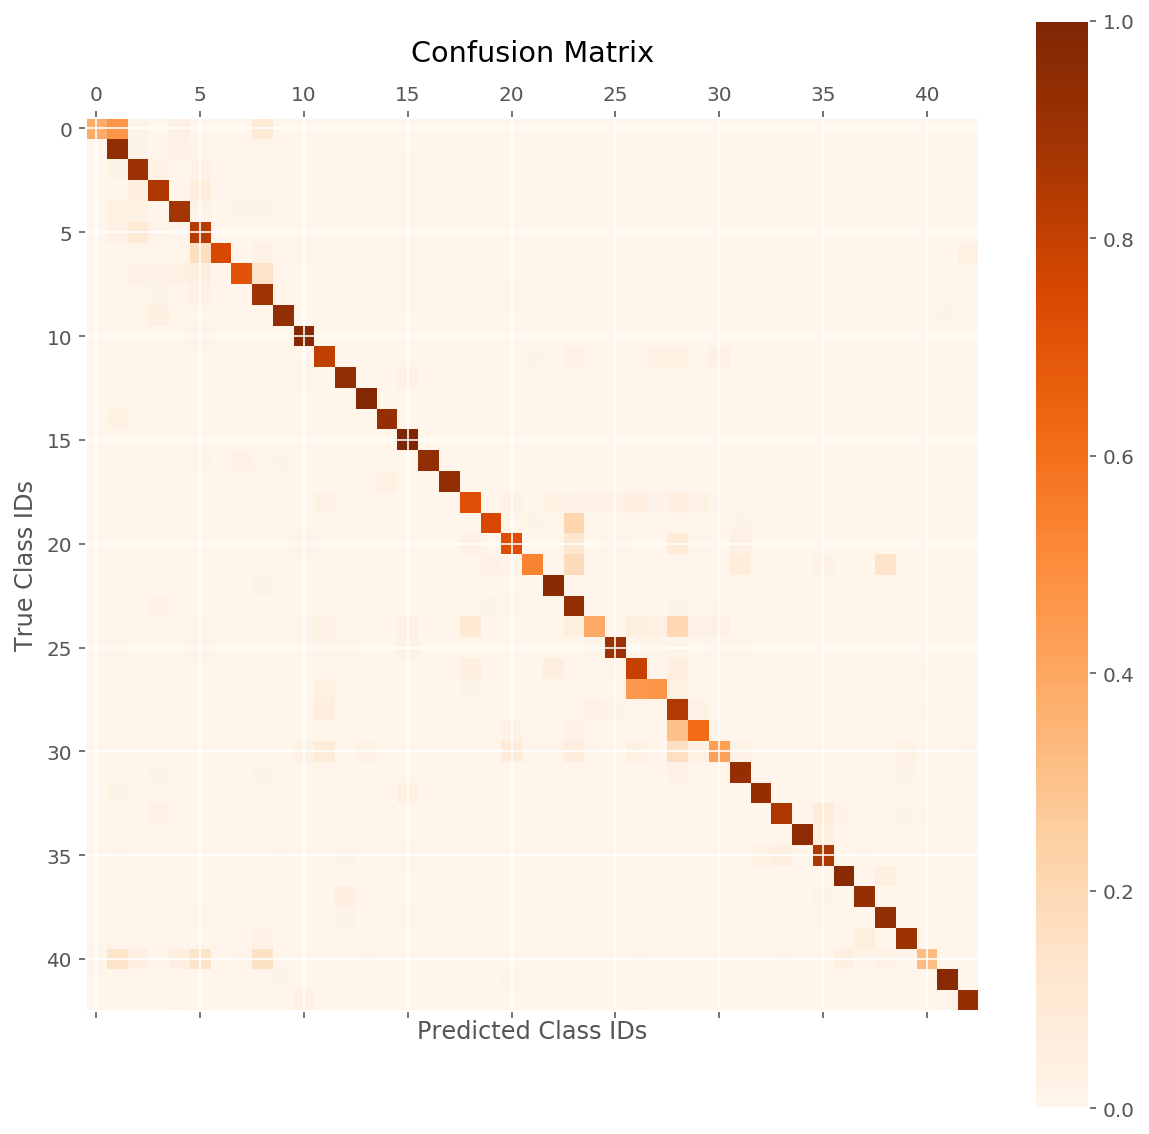

15 No vehicles                                        100.00%  566
13 Yield                                               98.33% 1940
10 No passing for vehicles over 3.5 metric tons        97.42% 1805
41 End of no passing                                   96.67%  216
22 Bumpy road                                          95.83%  350
36 Go straight or right                                95.83%  350
34 Turn left ahead                                     95.00%  377
 1 Speed limit (30km/h)                                94.17% 1994
12 Priority road                                       94.06% 1886
16 Vehicles over 3.5 metric tons prohibited            94.00%  377
38 Keep right                                          93.91% 1859
17 No entry                                            93.61%  997
 9 No passing                                          93.54% 1320
32 End of all speed and passing limits                 93.33%  216
37 Go straight or left                                 93.33% 

In [17]:
## Find Confusion Matrix to see how each classes performed 
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm)
print_confusion_matrix(cm)

## Learning Curve for training and validation data

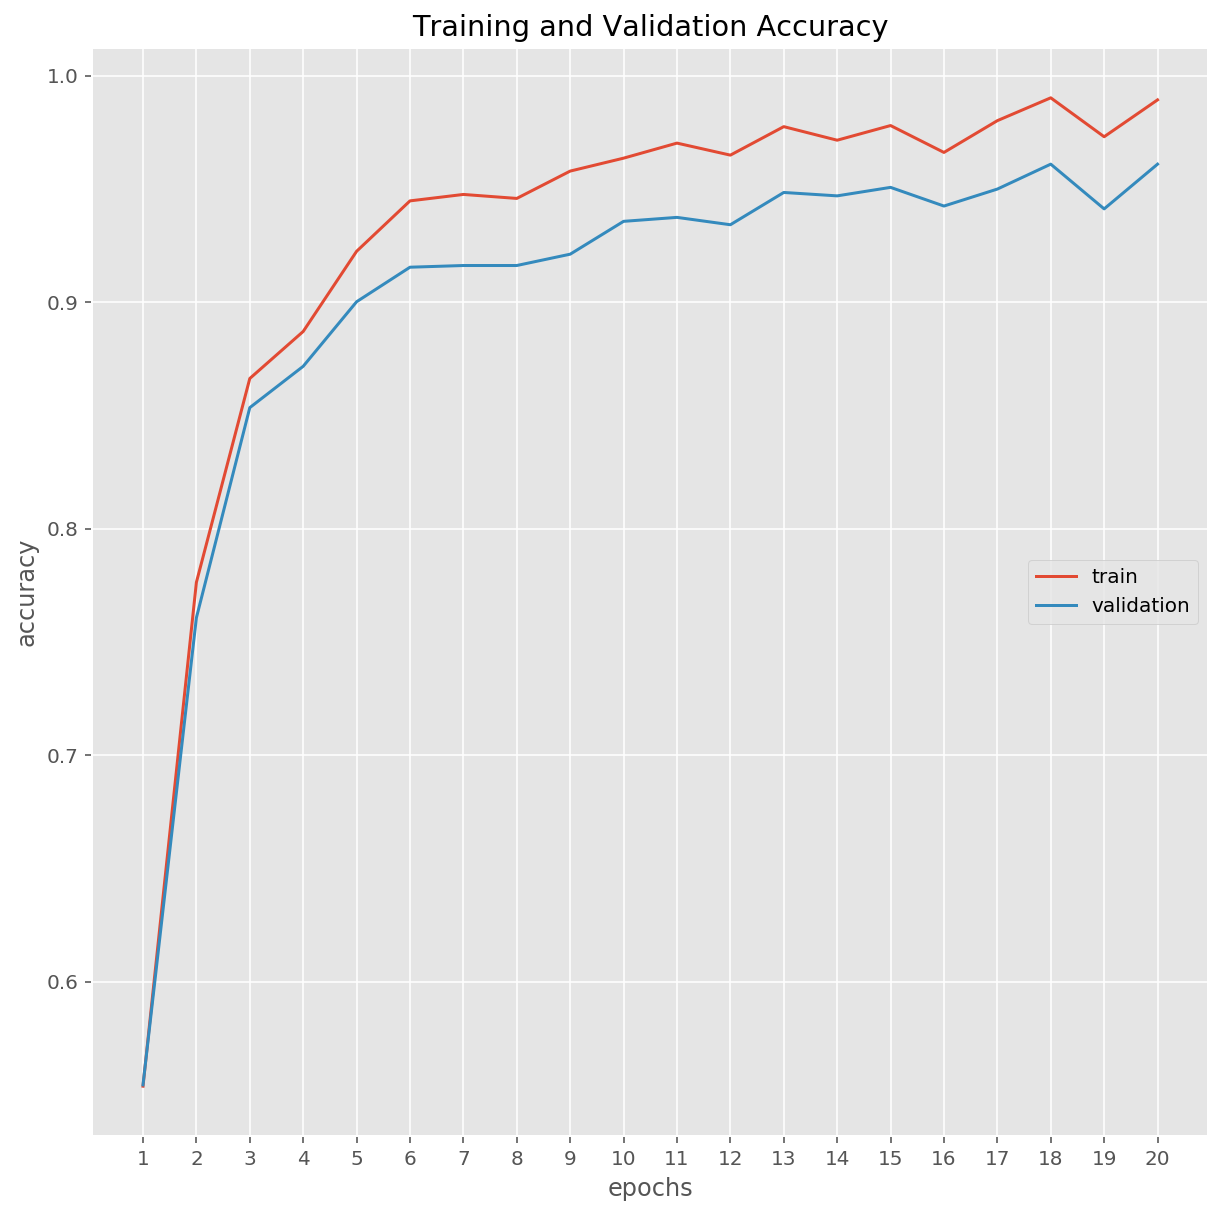

In [18]:
show_learning_curve(train_accuracy_figure, validation_accuracy_figure)

### Observation:

This proves the network is working properly. The performance is pretty good for the barebone network.

I can see a bit of overfitting. This is likely because the network is exposed to the same images over and over. At this moment, it is good to see the network is able to overfit and not showing high biases. The network can handle these images and able to learn from the data.

# Data Preprocessing

In [1]:
def preprocess_dataset(X, y, one_hot=False):
    '''
    - convert images to grayscale, 
    - scale from [0, 255] to [0, 1] range, 
    - use localized histogram equalization as images differ 
      in brightness and contrast significantly
    ADAPTED FROM: http://navoshta.com/traffic-signs-classification/
    '''

    #Convert to grayscale, e.g. single channel Y
    X = 0.299 * X[:, :, :, 0] + 0.587 * X[:, :, :, 1] + 0.114 * X[:, :, :, 2]

    #Scale features to be in [0, 1]
    X = (X / 255.).astype(np.float32)
    
    #adjust histogram
    for i in range(X.shape[0]):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            X[i] = exposure.equalize_adapthist(X[i]) 
    
    if one_hot:
        # Convert to one-hot encoding. Convert back with `y = y.nonzero()[1]`
        y = np.eye(43)[y]
    
    # Add a single grayscale channel
    X = X.reshape(X.shape + (1,)) 
    return X, y

def makeDict(X, y):
    return {'features': X, 'labels': y}

def retriveDataFromDict(dictn):
    return dictn['features'], dictn['labels']

In [20]:
training_preprocessed_file = "train_preprocessed.p"
validation_preprocessed_file = "valid_preprocessed.p"
testing_preprocessed_file = "test_preprocessed.p"

In [256]:
## Please run this only first time and save the data into file
## so next time, we can directly load from file.

print("Preprocessing the data to improve feature extraction...")
print("This might take a while...")

X_train_preprocessed, y_train_preprocessed = preprocess_dataset(X_train, y_train)
print("training set preprocessing complete!", X_train_preprocessed.shape)

X_valid_preprocessed, y_valid_preprocessed = preprocess_dataset(X_valid, y_valid)
print("cross validation set preprocessing complete!", X_valid_preprocessed.shape)

X_test_preprocessed, y_test_preprocessed = preprocess_dataset(X_test, y_test)
print("test set preprocessing complete!", X_test_preprocessed.shape)

Preprocessing the data to improve feature extraction...
This might take a while...
training set preprocessing complete! (35209, 32, 32, 1)
cross validation set preprocessing complete! (4000, 32, 32, 1)
test set preprocessing complete! (12630, 32, 32, 1)


In [265]:
# Save the preprocessed data set, so we don't have to preprocess it everytime 

pickle.dump(makeDict(X_train_preprocessed, y_train_preprocessed), open(training_preprocessed_file, "wb" ))
pickle.dump(makeDict(X_valid_preprocessed, y_valid_preprocessed), open(validation_preprocessed_file, "wb" ))
pickle.dump(makeDict(X_test_preprocessed, y_test_preprocessed), open(testing_preprocessed_file, "wb" ))

In [22]:
with open(training_preprocessed_file, mode='rb') as f:
    X_train_preprocessed, y_train_preprocessed = retriveDataFromDict(pickle.load(f))
with open(validation_preprocessed_file, mode='rb') as f:
    X_valid_preprocessed, y_valid_preprocessed = retriveDataFromDict(pickle.load(f))
with open(testing_preprocessed_file, mode='rb') as f:
    X_test_preprocessed, y_test_preprocessed = retriveDataFromDict(pickle.load(f))

## Let's see how our data looks like after preprocessing

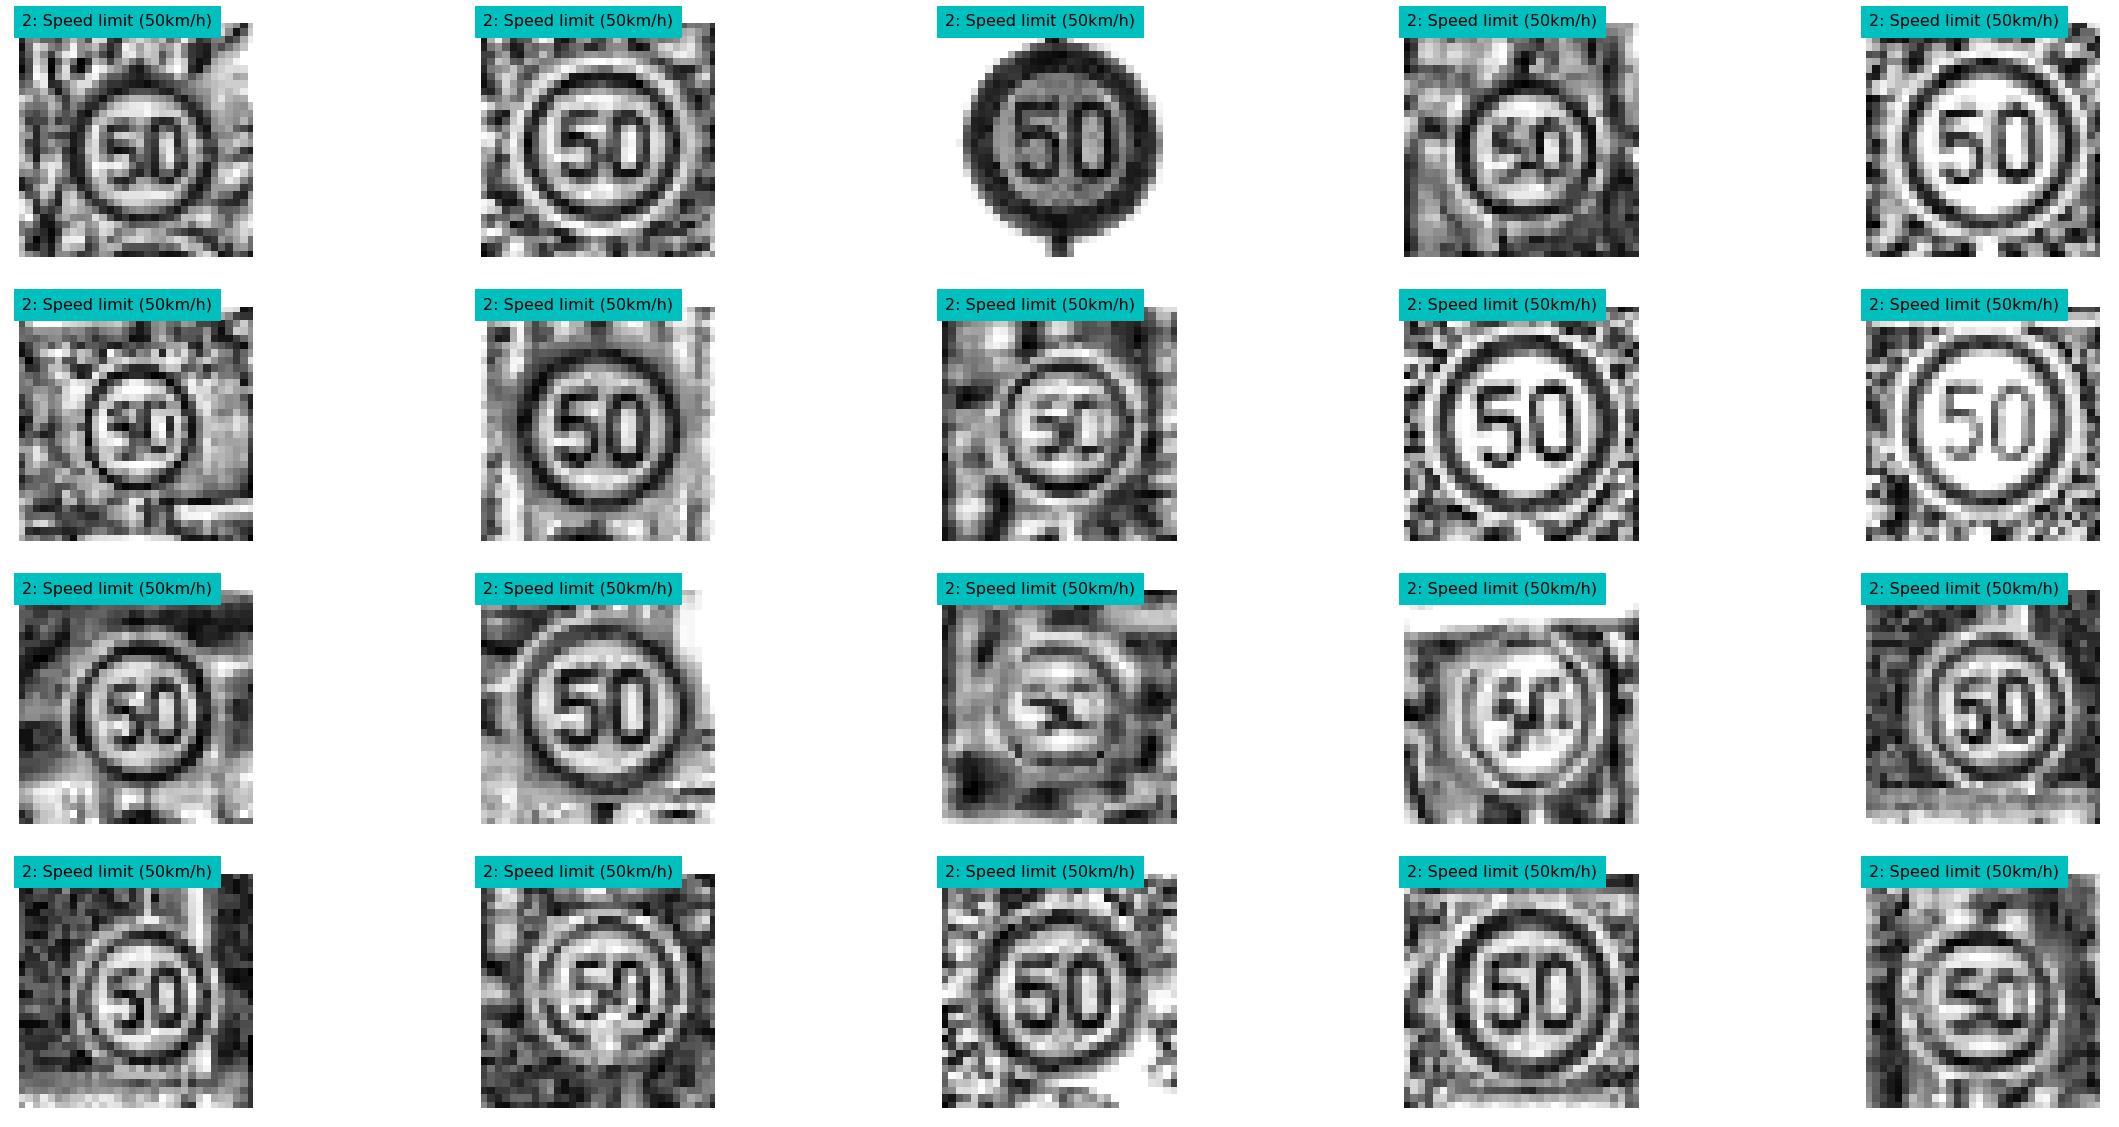

In [23]:
sample_x_2, sample_y_2 = get_samples(num_samples=20, class_id=2)
sample_x_2_preprocessed, sample_y_2_preprocessed = preprocess_dataset(sample_x_2, sample_y_2, one_hot=False)
show_images(sample_x_2_preprocessed, sample_y_2_preprocessed, sign_names=SIGN_NAMES, show_shape=False)

## Testing the model on Preprocessed Images

In [24]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)

In [25]:
def run_LeNet_with_normalized_data():

    BATCH_SIZE = 128
    NUMBER_OF_TRAINING_DATA = X_train_preprocessed.shape[0]
    EPOCHS = 20
    DIR = 'Saved_Models'

    LeNet_Model_norm = LaNet(n_out = 43, input_channels = 1)
    model_name = "LeNet_normalized"
    validation_accuracy_figure = []
    train_accuracy_figure = []

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        num_examples = len(y_train_preprocessed)
        print("Training ...")
        print()
        for epoch in range(EPOCHS):
            X_data, y_data = shuffle(X_train_preprocessed, y_train_preprocessed)
            for offset in range(0, NUMBER_OF_TRAINING_DATA, BATCH_SIZE):
                batch_x, batch_y = LeNet_Model_norm.get_batch(X_data, y_data, offset, BATCH_SIZE) 
                _, loss = sess.run([LeNet_Model_norm.training_operation, LeNet_Model_norm.loss_operation], feed_dict={x: batch_x, y: batch_y, keep_prob : 0.5})

            validation_accuracy = LeNet_Model_norm.evaluate(X_valid_preprocessed, y_valid_preprocessed)
            validation_accuracy_figure.append(validation_accuracy)

            train_accuracy = LeNet_Model_norm.evaluate(X_train_preprocessed, y_train_preprocessed)
            train_accuracy_figure.append(train_accuracy)

            print("Epoch: {:3d},".format(epoch), "Train Acc: {:.3f}, ".format(train_accuracy), 
                  "Validation Acc: {:.3f}, ".format(validation_accuracy), 
                  "loss: {:.3f}".format(loss))
        LeNet_Model_norm.saver.save(sess, os.path.join(DIR, model_name))
        print("Model saved")

    return LeNet_Model_norm, train_accuracy_figure, validation_accuracy_figure

In [26]:
LeNet_Model_norm, train_accuracy_norm, validation_accuracy_norm = run_LeNet_with_normalized_data()

Training ...

Epoch:   0, Train Acc: 0.795,  Validation Acc: 0.796,  loss: 0.232
Epoch:   1, Train Acc: 0.909,  Validation Acc: 0.902,  loss: 0.177
Epoch:   2, Train Acc: 0.954,  Validation Acc: 0.942,  loss: 0.018
Epoch:   3, Train Acc: 0.961,  Validation Acc: 0.949,  loss: 0.083
Epoch:   4, Train Acc: 0.973,  Validation Acc: 0.960,  loss: 0.082
Epoch:   5, Train Acc: 0.977,  Validation Acc: 0.960,  loss: 0.045
Epoch:   6, Train Acc: 0.981,  Validation Acc: 0.964,  loss: 0.029
Epoch:   7, Train Acc: 0.988,  Validation Acc: 0.974,  loss: 0.009
Epoch:   8, Train Acc: 0.987,  Validation Acc: 0.969,  loss: 0.007
Epoch:   9, Train Acc: 0.989,  Validation Acc: 0.974,  loss: 0.291
Epoch:  10, Train Acc: 0.987,  Validation Acc: 0.971,  loss: 0.001
Epoch:  11, Train Acc: 0.988,  Validation Acc: 0.972,  loss: 0.006
Epoch:  12, Train Acc: 0.989,  Validation Acc: 0.976,  loss: 0.002
Epoch:  13, Train Acc: 0.995,  Validation Acc: 0.979,  loss: 0.003
Epoch:  14, Train Acc: 0.991,  Validation Acc: 0

In [27]:
# EVALUATE USING TEST DATA 

with tf.Session() as sess:
    LeNet_Model_norm.saver.restore(sess, os.path.join('Saved_Models', "LeNet_normalized"))
    y_pred_preprocessed = LeNet_Model_norm.y_predict(X_test_preprocessed)
    test_accuracy = sum(y_test_preprocessed == y_pred_preprocessed)/len(y_test_preprocessed)
    print("Test Accuracy = {:.1f}%".format(test_accuracy*100))

Test Accuracy = 93.9%


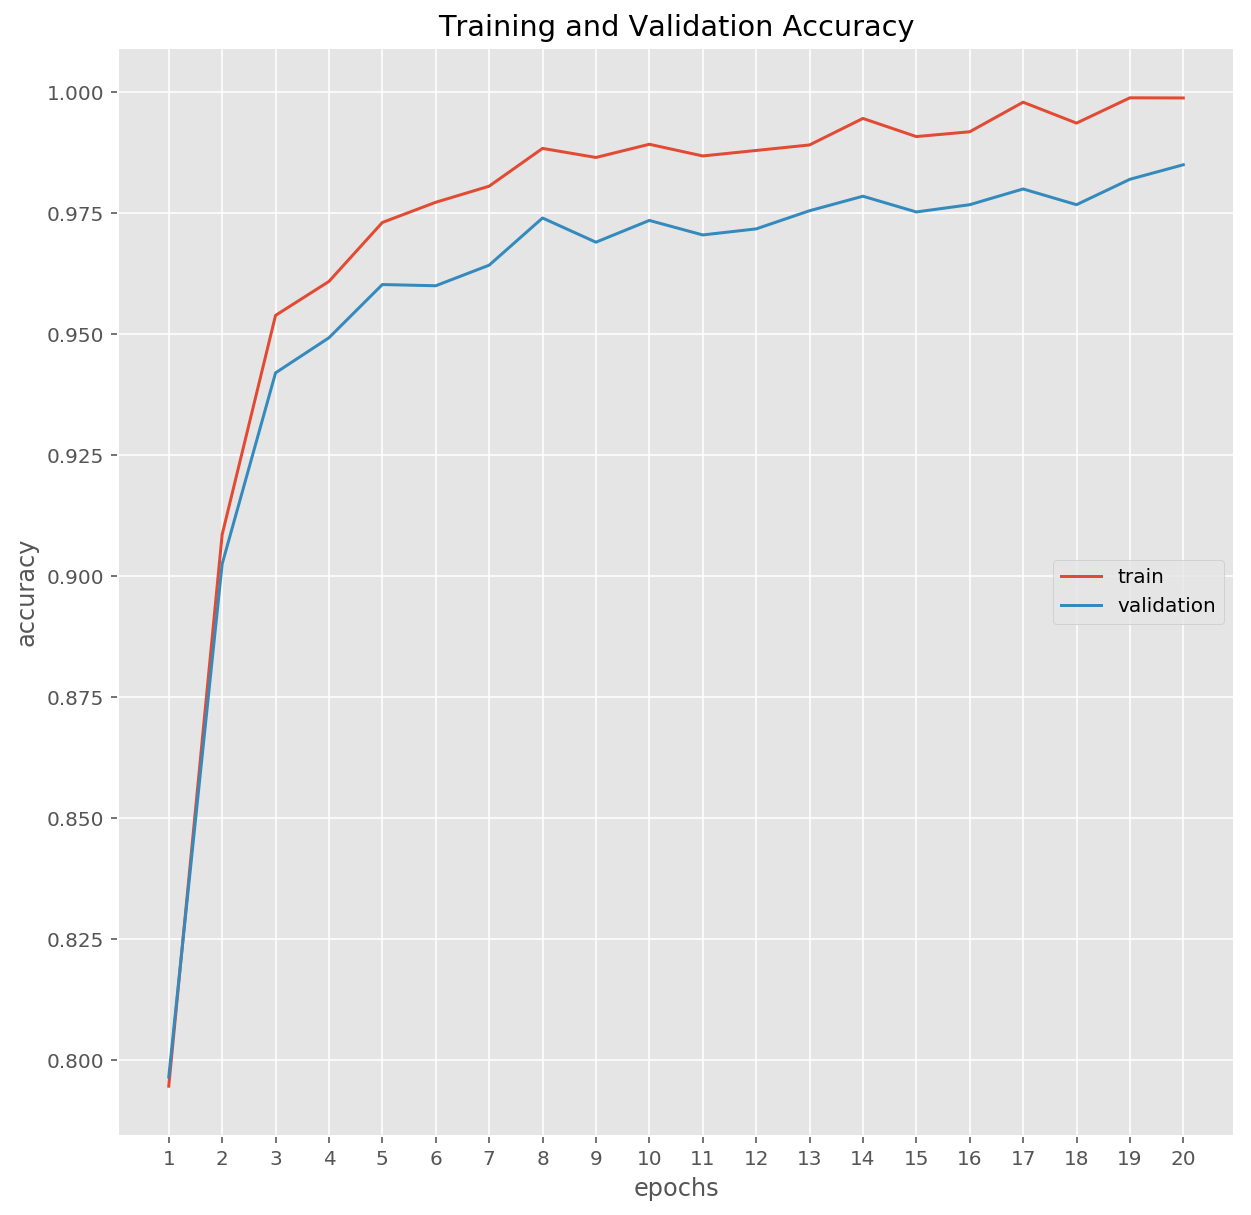

In [28]:
show_learning_curve(train_accuracy_norm, validation_accuracy_norm)

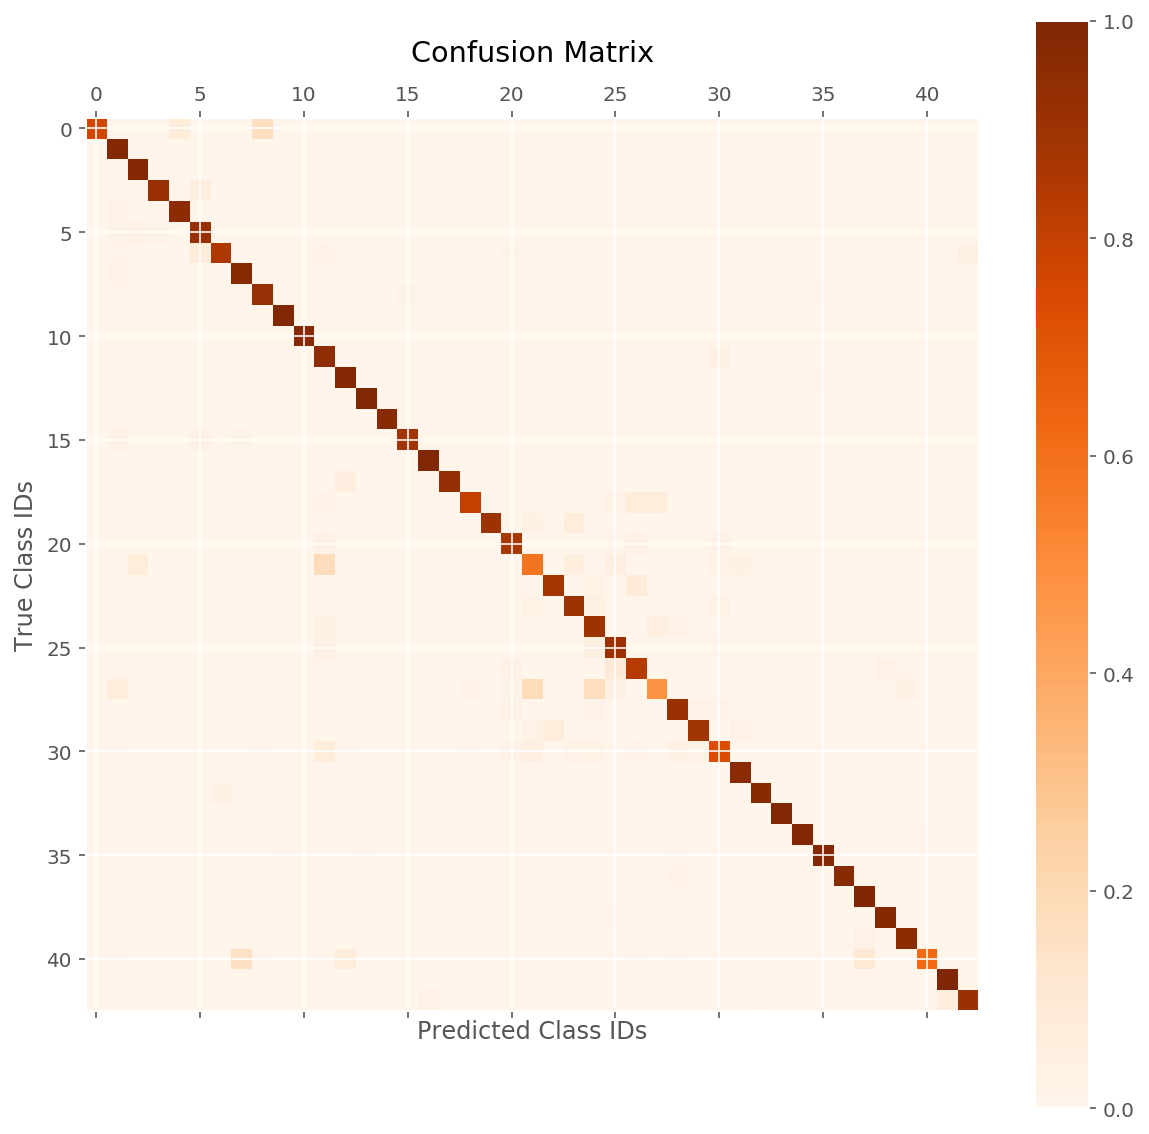

37 Go straight or left                                100.00%  189
41 End of no passing                                  100.00%  216
 9 No passing                                          99.58% 1320
13 Yield                                               99.58% 1940
33 Turn right ahead                                    99.52%  619
16 Vehicles over 3.5 metric tons prohibited            99.33%  377
34 Turn left ahead                                     99.17%  377
35 Ahead only                                          98.46% 1078
12 Priority road                                       98.41% 1886
 2 Speed limit (50km/h)                                98.27% 2020
 1 Speed limit (30km/h)                                98.06% 1994
38 Keep right                                          97.83% 1859
10 No passing for vehicles over 3.5 metric tons        97.58% 1805
 7 Speed limit (100km/h)                               96.89% 1293
14 Stop                                                96.67% 

In [29]:
cm_preprocessed = confusion_matrix(y_test_preprocessed, y_pred_preprocessed)
plot_confusion_matrix(cm_preprocessed)
print_confusion_matrix(cm_preprocessed)

**Observations**

As per the confusion matrix observation, it seems like various speed limits are sometimes misclassified among themselves. Similarly, traffic signs with traingular shape are misclassified among themselves. We can further improve on the model using hierarchical CNNs to first identify broader groups (like speed signs) and then have CNNs to classify finer features (such as the actual speed limit). 

# Test a Model on New Images

In [30]:
# Read the images

def get_new_test_images(folder_name):
    i=1
    images_sign = list()
    labels_sign = list()
    for line in open(folder_name + '/data.txt','r'):
        fname, label = line.strip().split(' ')
        label = int(label)
        fname = folder_name + '/' + fname
        img = cv2.imread(fname)
        # Our images are of different sizes so we need to convert them into 32x32 size.
        img = cv2.resize(img, (32,32))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        images_sign.append(img)
        labels_sign.append(label)

    images = np.array(images_sign)
    labels = np.array(labels_sign)
    
    return images, labels

In [31]:
images, labels = get_new_test_images('my_sign_images')

## Sign Images from Web

./my_sign_images/sign10.png
./my_sign_images/sign4.png
./my_sign_images/sign7.png
./my_sign_images/sign8.png
./my_sign_images/sign9.png
./my_sign_images/001.jpg
./my_sign_images/002.jpg
./my_sign_images/003.jpg
./my_sign_images/004.jpg
./my_sign_images/005.jpg


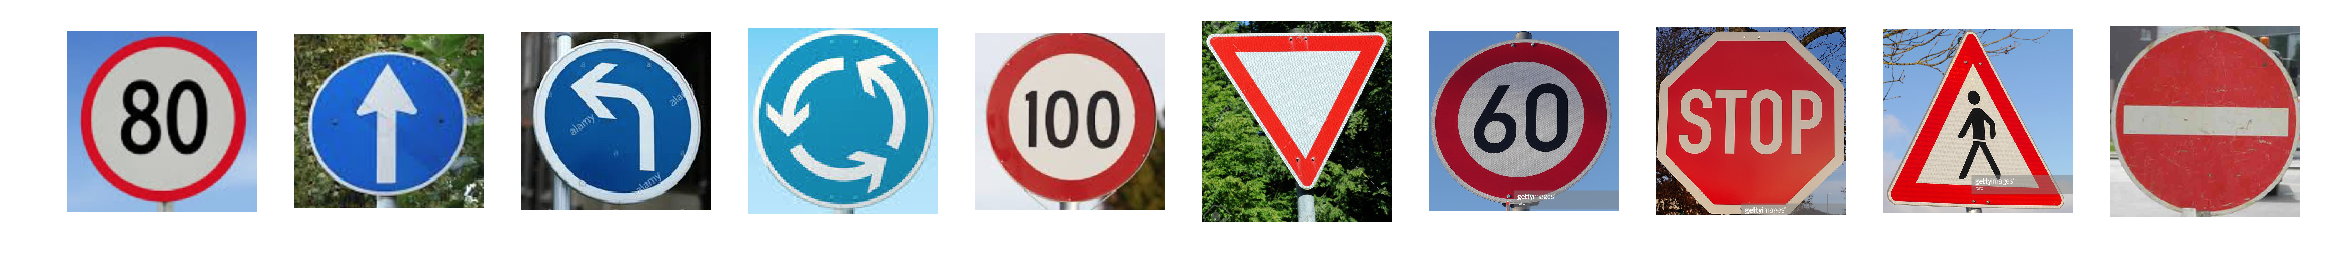

In [9]:
import skimage
from skimage import io
import glob

i=1
plt.figure(figsize=(20,15))
for el in glob.glob('./my_sign_images/*.png') + glob.glob('./my_sign_images/*.jpg'):
    print(el)
    img = io.imread(el)    
    
    plt.subplot(1,10,i)
    plt.imshow(img)
    i+=1
    plt.axis('off')
    
plt.savefig('images/new_images.png',bbox_inches='tight')

## Run the pipeline on new web images

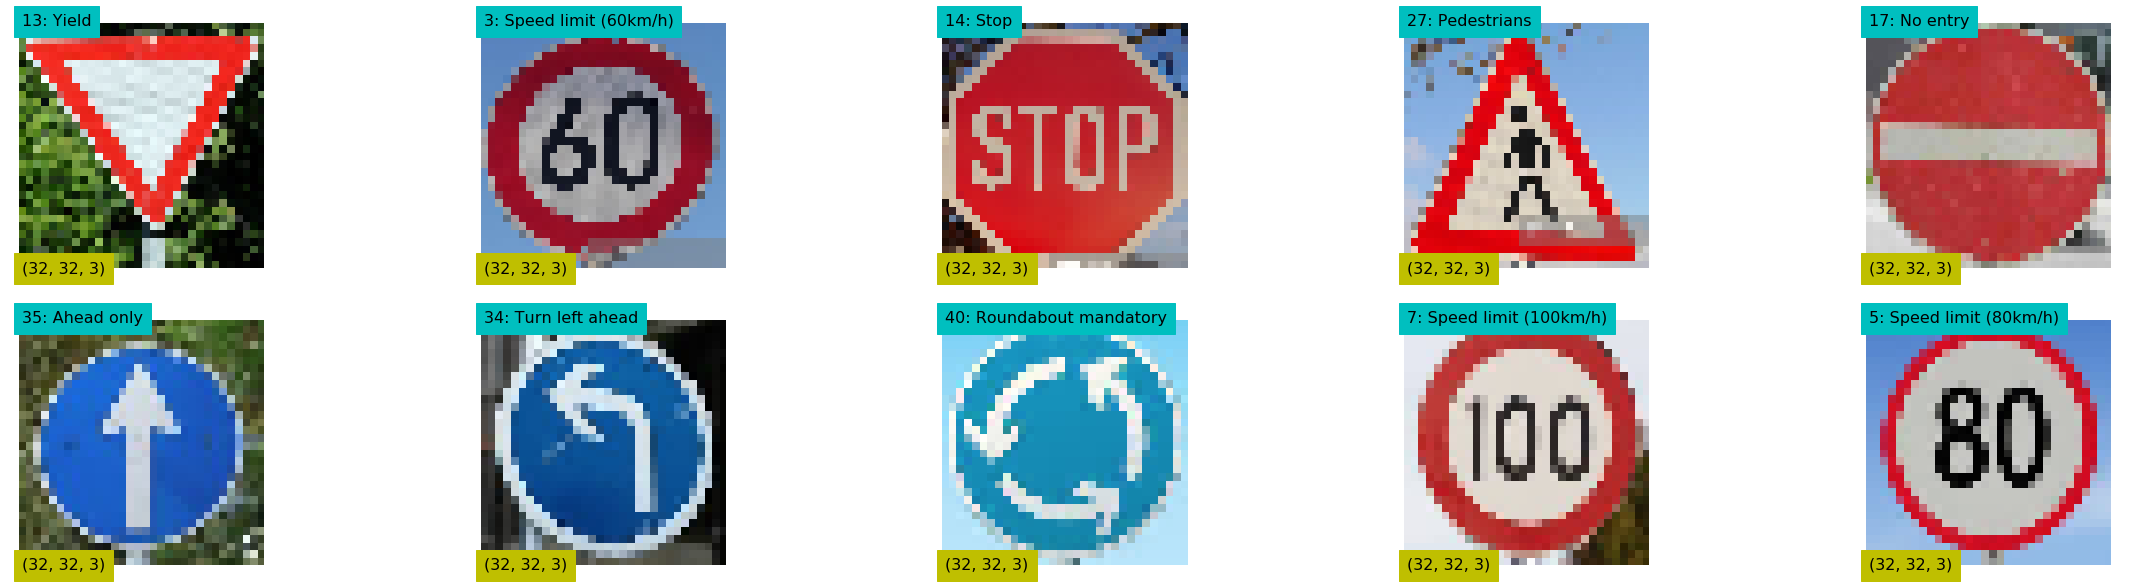

In [32]:
show_images(images, labels, cols=5, sign_names=SIGN_NAMES, show_shape=True)

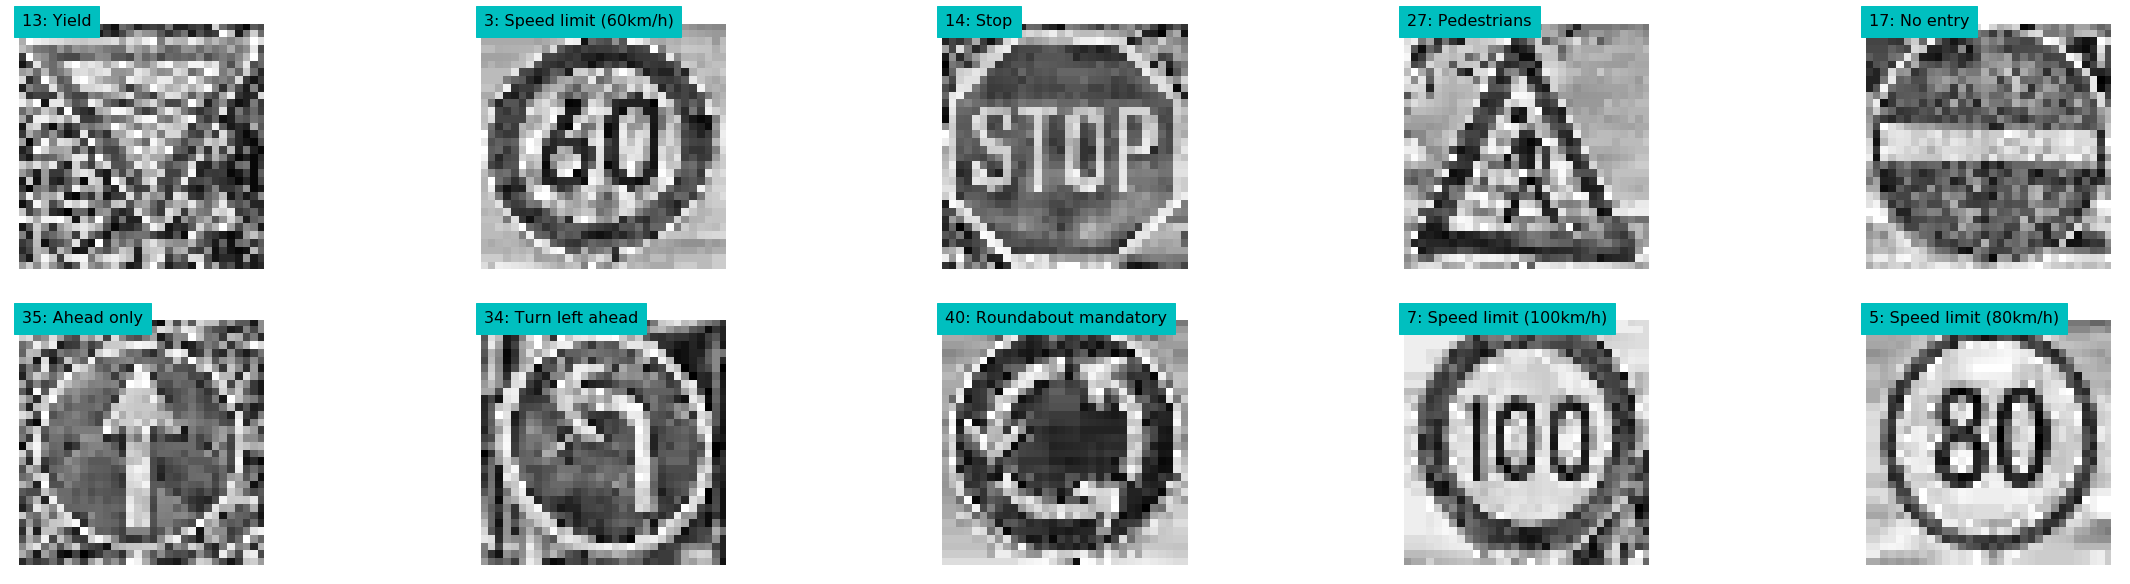

In [33]:
X_test_new, y_test_new = preprocess_dataset(images, labels)
show_images(X_test_new, y_test_new, cols=5, sign_names=SIGN_NAMES, show_shape=False)

In [34]:
def y_predict_model(Input_data, top_k=5):
    """
    Generates the predictions of the model over the input data, and outputs the top softmax probabilities.
    Parameters:
        X_data: Input data.
        top_k (Default = 5): The number of top softmax probabilities to be generated.
    """
    num_examples = len(Input_data)
    y_pred = np.zeros((num_examples, top_k), dtype=np.int32)
    y_prob = np.zeros((num_examples, top_k))
    with tf.Session() as sess:
        LeNet_Model_norm.saver.restore(sess, os.path.join('Saved_Models', "LeNet_normalized"))
        y_prob, y_pred = sess.run(tf.nn.top_k(tf.nn.softmax(LeNet_Model_norm.logits), k=top_k), 
                             feed_dict={x:Input_data, keep_prob:1})
    return y_prob, y_pred

y_prob, y_pred = y_predict_model(X_test_new)


## Softmax Probablities

New Images Test Accuracy = 50.0%


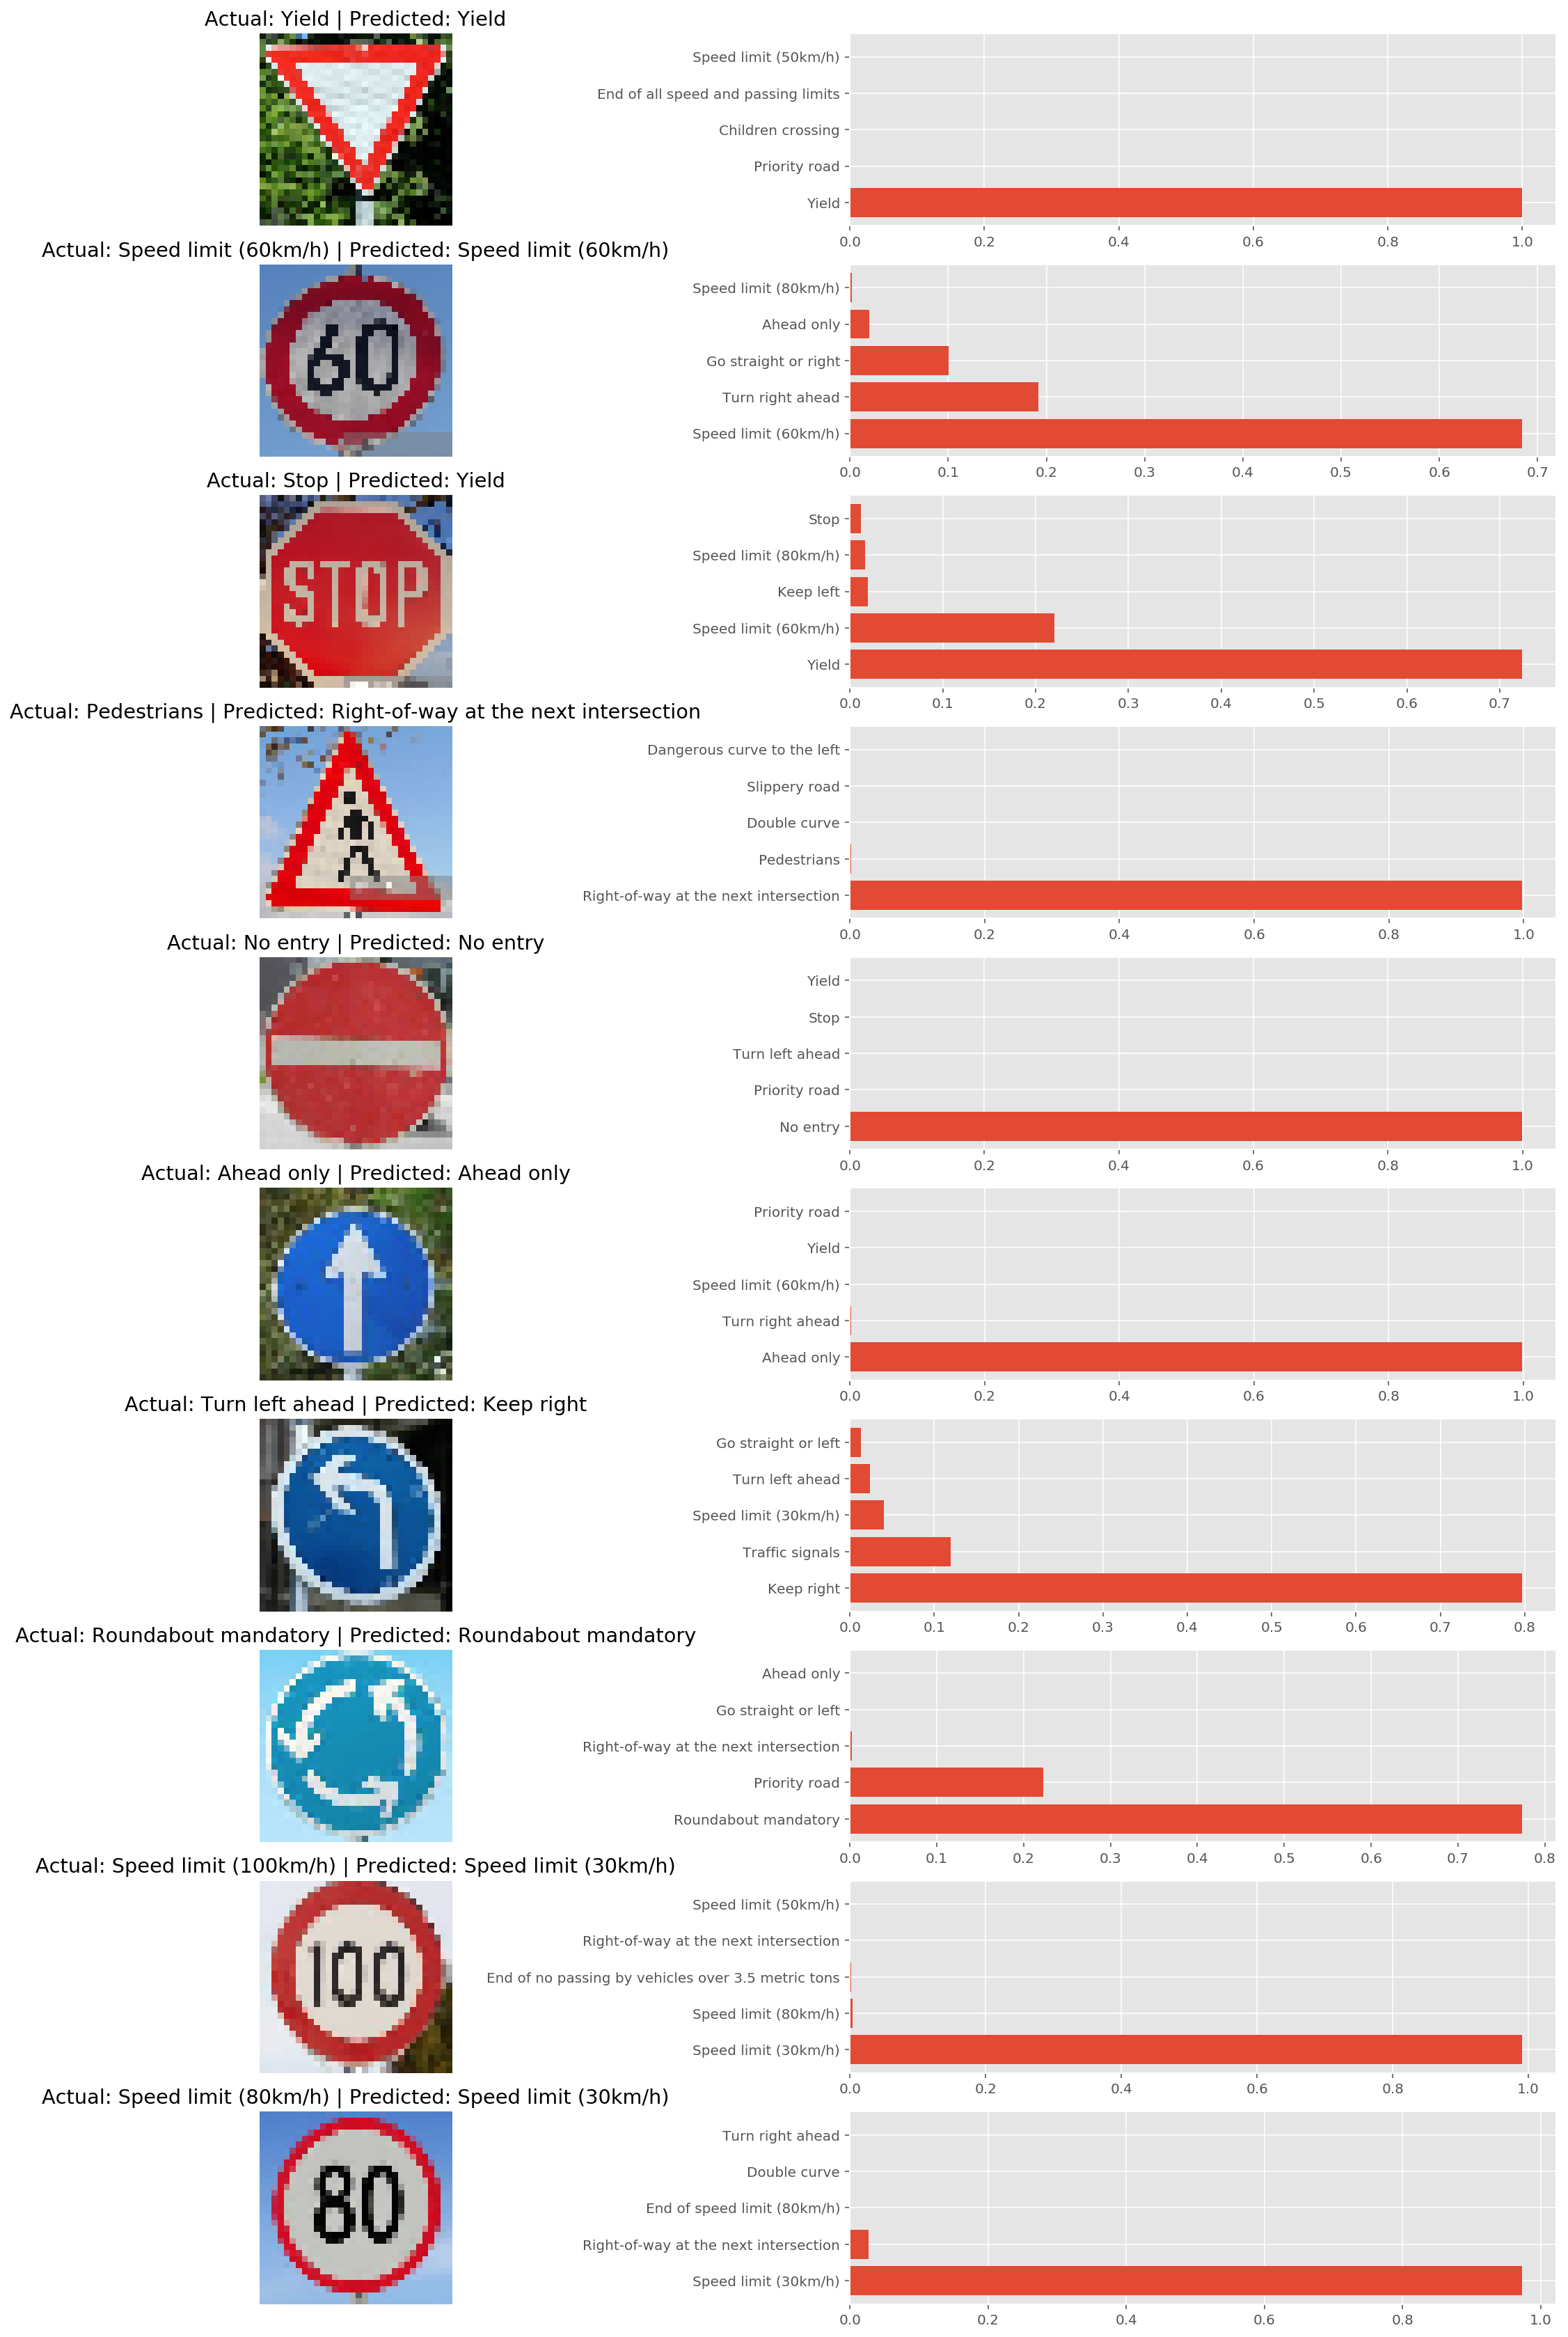

In [35]:
test_accuracy = 0
for i in range(len(X_test_new)):
    accu = y_test_new[i] == np.asarray(y_pred[i])[0]
    if accu == True:
        test_accuracy += 0.1
print("New Images Test Accuracy = {:.1f}%".format(test_accuracy*100))

plt.figure(figsize=(20, 30))
for i in range(len(X_test_new)):
    plt.subplot(len(X_test_new), 2, 2*i+1)
#     print(images[i].shape)
    plt.imshow(images[i]) 
    plt.title('Actual: ' + get_name_from_label(y_test_new[i]) + ' | Predicted: ' + get_name_from_label(y_pred[i][0]))
    plt.axis('off')
    plt.subplot(len(X_test_new), 2, 2*i+2)
    plt.barh(np.arange(1, 6, 1), y_prob[i, :])
    labels = [get_name_from_label(j) for j in y_pred[i]]
    plt.yticks(np.arange(1, 6, 1), labels)
plt.show()

**Observation**:

- 5 out of 10 are correct.

As we can notice from the top 5 softmax probabilities, the model has very high confidence (100%) when it comes to predict simple signs, like the "Yield" and the "No entry" sign, but having hard time predicting complex signs.

I can understand why it did not identify some of the signs correctly as our dataset is really skewed. It also could be some of the signs are not in our training set. For an example, for every country / region, we'd need to train the classifier to recognize their traffic signs.

As for the speed limits (80km and 100km), I'm thinking it is may be due to the image distortion by the resizing operation.  We may need a better way to resize images.  But this is yet to be proven at this stage.

# Conclusion

This pipeline was very effective during the experimentations. In the end, the traffic sign classifier works pretty well overall with the test set.  

However, the network did not work as good with ramdom sample images from the internet.  

Moreover, if a self-driving car needs to find traffic signs in public, it first needs to know where the traffic signs are. For speeding signs, we may need an OCR (object recognition) mechanism that scan across the image with sliding windows to find the candidate signs.  This kind of detection mechanism is not covered in this project.